In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# check submission format for Round 1 
sample_pred = pd.read_csv('data/MSampleSubmissionStage1_2020.csv')
display(sample_pred.head())
print(len(sample_pred))

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


11390


# Import Data

In [3]:
tourney_results = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_results.info()
tourney_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 8 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
dtypes: int64(7), object(1)
memory usage: 140.8+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [33]:
teams = pd.read_csv('data/MDataFiles_Stage1/MTeams.csv')
teams.info()
teams[teams['TeamName'].str.contains('Villanova|North Carolina')] # these teams actually never met in NCAA Tournament 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
TeamID           367 non-null int64
TeamName         367 non-null object
FirstD1Season    367 non-null int64
LastD1Season     367 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.5+ KB


,TeamID,TeamName,FirstD1Season,LastD1Season
213,1314,North Carolina,1985,2020
336,1437,Villanova,1985,2020


In [38]:
regular_results = pd.read_csv('data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv') 
regular_results.info()
regular_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161552 entries, 0 to 161551
Data columns (total 8 columns):
Season     161552 non-null int64
DayNum     161552 non-null int64
WTeamID    161552 non-null int64
WScore     161552 non-null int64
LTeamID    161552 non-null int64
LScore     161552 non-null int64
WLoc       161552 non-null object
NumOT      161552 non-null int64
dtypes: int64(7), object(1)
memory usage: 9.9+ MB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [39]:
seeds = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seeds.info()
seeds.query("TeamID == 1314") # UNC seedings through the years 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 3 columns):
Season    2286 non-null int64
Seed      2286 non-null object
TeamID    2286 non-null int64
dtypes: int64(2), object(1)
memory usage: 53.7+ KB


,Season,Seed,TeamID
49,1985,Z02,1314
114,1986,Z03,1314
128,1987,W01,1314
241,1988,Z02,1314
305,1989,Z02,1314
343,1990,X08,1314
384,1991,W01,1314
499,1992,Z04,1314
512,1993,W01,1314
576,1994,W01,1314


# Helper Functions

In [7]:
def clf_eda_numeric(data, feature, target='Won'):
    """ Creates EDA plots for a binary target vs. a select numeric feature """
    
    # set up axes and define attributes 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
    neutral_color = list(plt.rcParams['axes.prop_cycle'])[3]['color']
    
    # top-left: boxplot 
    sns.boxplot(x=target, y=feature, data=data, ax=axes[0,0]) 
    
    # top-right: overlapping density plots, 1 for each class  
    for y in [0,1]:
        subset = data[data[target]==y]
        sns.distplot(subset[feature], label=y, ax=axes[0,1])
        xmin, xmax = data[feature].min(), data[feature].max()
        axes[0,1].set_xlim(xmin, xmax)
        axes[0,1].set_ylabel('Density')
        axes[0,1].legend()
        
    # bottom-left: line plot of average target by feature value  
    sns.lineplot(x=feature, y=target, color=neutral_color, data=data, ax=axes[1,0])
    
    # bottom-right: histogram of combined data 
    sns.distplot(data[feature], kde=False, norm_hist=True, label='Density', color=neutral_color, ax=axes[1,1])

# Construct Dataset + EDA

### Create IDs and Labels

Each observation in our dataset is a March Madness match-up between two teams in a particular season, uniquely identified by a SSSS_XXXX_YYYY ID, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team. The label of this observation is the outcome of the game, indicating whether the lower-ID team wins (1) or loses (0). 

In [8]:
def reformat_obs(tourney_results):
    """ Given tourney results, reformat and append dataframe with unique ID and label """
    
    data = tourney_results.assign(
        TeamA = lambda x: x[['WTeamID','LTeamID']].min(axis=1), 
        TeamB = lambda x: x[['WTeamID','LTeamID']].max(axis=1), 
        Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str),
        ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'],
        Won = lambda x: np.where(x['WTeamID'] < x['LTeamID'], 1, 0),
        ScoreTeamA = lambda x: np.where(x['WTeamID'] == x['TeamA'], x['WScore'], x['LScore']),
        ScoreTeamB = lambda x: np.where(x['WTeamID'] == x['TeamB'], x['WScore'], x['LScore']),
        ScoreDiff = lambda x: x['ScoreTeamA'] - x['ScoreTeamB']
    )
    
    cols_to_return = ['ID', 'Season', 'TeamA', 'TeamB', 'Teams', 'Won', 
                      'ScoreTeamA', 'ScoreTeamB', 'ScoreDiff', 'DayNum', 'NumOT', 'WLoc']
    
    return data[cols_to_return] 

In [44]:
data = reformat_obs(tourney_results)
data.info()
display(data.query("Teams == '1314_1437'")) # UNC-Villanova head-to-heads 
data['Won'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 12 columns):
ID            2251 non-null object
Season        2251 non-null int64
TeamA         2251 non-null int64
TeamB         2251 non-null int64
Teams         2251 non-null object
Won           2251 non-null int64
ScoreTeamA    2251 non-null int64
ScoreTeamB    2251 non-null int64
ScoreDiff     2251 non-null int64
DayNum        2251 non-null int64
NumOT         2251 non-null int64
WLoc          2251 non-null object
dtypes: int64(9), object(3)
memory usage: 211.1+ KB


,ID,Season,TeamA,TeamB,Teams,Won,ScoreTeamA,ScoreTeamB,ScoreDiff,DayNum,NumOT,WLoc
59,1985_1314_1437,1985,1314,1437,1314_1437,0,44,56,-12,146,0,N
421,1991_1314_1437,1991,1314,1437,1314_1437,1,84,69,15,139,0,N
1319,2005_1314_1437,2005,1314,1437,1314_1437,1,67,66,1,144,0,N
1582,2009_1314_1437,2009,1314,1437,1314_1437,1,83,69,14,152,0,N
1814,2013_1314_1437,2013,1314,1437,1314_1437,1,78,71,7,137,0,N
2049,2016_1314_1437,2016,1314,1437,1314_1437,0,74,77,-3,154,0,N


1    1137
0    1114
Name: Won, dtype: int64

### Create Seed Features

Here we append three features to our dataset: seedings of the respective teams for that season (`SeedA` for the lower-ID team and `SeedB` for the higher-ID team) and the difference between the two (`SeedDiff`=SeedB-SeedA). We expect the latter to be one of the most predictive features of the game outcome. 

In [45]:
def append_seed_features(data, seeds):
    """ Create seed features and append to main dataframe """
    seeds = seeds.copy() 
    seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds = seeds.set_index(['Season', 'TeamID'])
    df = data.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
             .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('A', 'B'))
    df['SeedDiff'] = df['SeedB'] - df['SeedA'] 
    return df 

In [51]:
data2 = append_seed_features(data, seeds)
data2.query("Teams == '1314_1437'")

,ID,Season,TeamA,TeamB,Teams,Won,ScoreTeamA,ScoreTeamB,ScoreDiff,DayNum,NumOT,WLoc,SeedA,SeedB,SeedDiff
59,1985_1314_1437,1985,1314,1437,1314_1437,0,44,56,-12,146,0,N,2,8,6
421,1991_1314_1437,1991,1314,1437,1314_1437,1,84,69,15,139,0,N,1,9,8
1319,2005_1314_1437,2005,1314,1437,1314_1437,1,67,66,1,144,0,N,1,5,4
1582,2009_1314_1437,2009,1314,1437,1314_1437,1,83,69,14,152,0,N,1,3,2
1814,2013_1314_1437,2013,1314,1437,1314_1437,1,78,71,7,137,0,N,8,9,1
2049,2016_1314_1437,2016,1314,1437,1314_1437,0,74,77,-3,154,0,N,1,2,1


Not surprisingly, the higher a team is seeded, the more likely it is to win. 

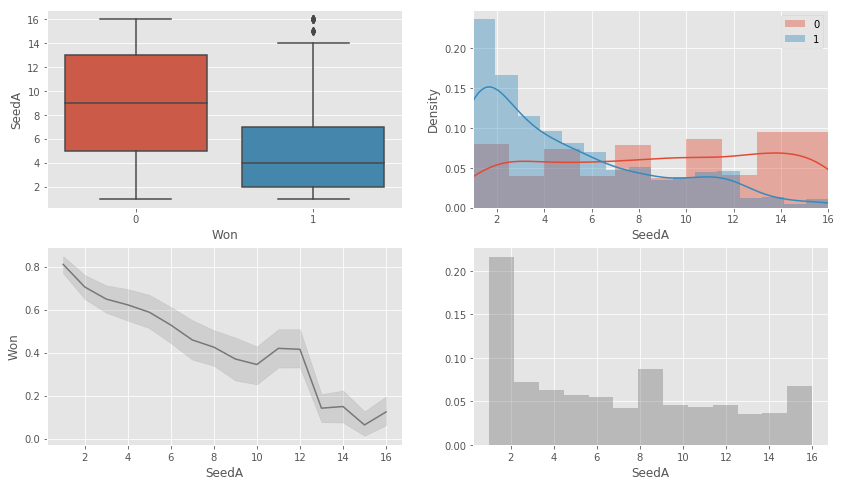

In [52]:
clf_eda_numeric(data2, feature='SeedA')

Conversely, the higher a team's opponent is seeded, the less likely a team is to win. 

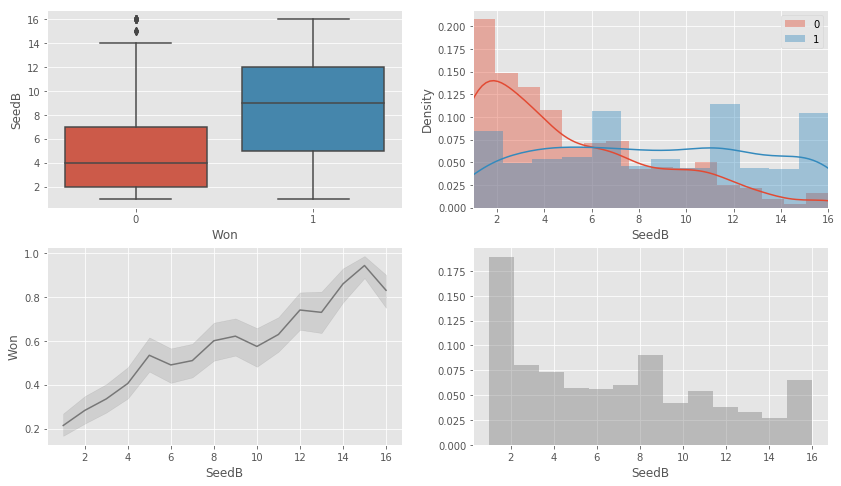

In [53]:
clf_eda_numeric(data2, feature='SeedB')

Perhaps the relative seeding of the teams is the most telling: conventional wisdom assumes the higher-seeded team wins, and the greater the gap in seedings, the higher the probability of winning. Our EDA below appears mostly consistent with our intuition.

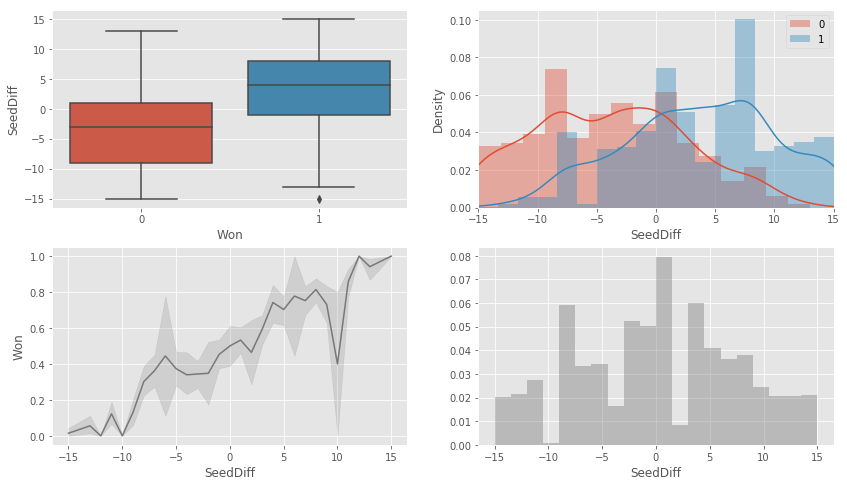

In [54]:
clf_eda_numeric(data2, feature='SeedDiff')

### Create historical tourney head-to-head features 

In [55]:
def append_tourney_head_to_head(data):
    """ Given data w/ tourney results, append head-to-head features """
    
    # generate head-to-head metrics 
    tourney_h2h = data\
        .merge(data, how='left', on='Teams', suffixes=('_1', '_2'))\
        .query("Season_1 > Season_2")\
        .groupby(['Teams', 'Season_1'])\
        .agg({'Won_2': ['size', np.sum]})\
        .reset_index()
    tourney_h2h.columns = ['Teams', 'Season', 'TourneyH2HTotal', 'TourneyH2HWins']
    tourney_h2h['TourneyH2HLosses'] = tourney_h2h['TourneyH2HTotal'] - tourney_h2h['TourneyH2HWins']
    tourney_h2h['TourneyH2HEdge'] = tourney_h2h['TourneyH2HWins'] - tourney_h2h['TourneyH2HLosses']
    
    # append to main dataframe 
    output = data.merge(tourney_h2h, how='left', on=['Season','Teams']).fillna(0)
    for col in ['TourneyH2HTotal', 'TourneyH2HWins', 'TourneyH2HLosses', 'TourneyH2HEdge']:
        output[col] = output[col].astype(int)
    
    return output

In [56]:
data3 = append_tourney_head_to_head(data2)
data3.query("Teams == '1314_1437'").T

,59,421,1319,1582,1814,2049
ID,1985_1314_1437,1991_1314_1437,2005_1314_1437,2009_1314_1437,2013_1314_1437,2016_1314_1437
Season,1985,1991,2005,2009,2013,2016
TeamA,1314,1314,1314,1314,1314,1314
TeamB,1437,1437,1437,1437,1437,1437
Teams,1314_1437,1314_1437,1314_1437,1314_1437,1314_1437,1314_1437
Won,0,1,1,1,1,0
ScoreTeamA,44,84,67,83,78,74
ScoreTeamB,56,69,66,69,71,77
ScoreDiff,-12,15,1,14,7,-3
DayNum,146,139,144,152,137,154


# Fit Model

### Helper Functions 

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score

In [79]:
# here we define a train/test split function to use all data preceding each season to train a model 

def train_test_period_split(data, season_to_predict, season_to_start=1985): 
    """ Split data into train vs. test datasets. 
        - Test set comprises only the single season specified; 
        - Train set comprises all data between season_to_start through the season before the one to predict on 
    """
    
    train_data = data.query("Season >= @season_to_start & Season < @season_to_predict")
    test_data = data.query("Season == @season_to_predict")

    return train_data, test_data

In [89]:
def evaluate_predictions(y_true, y_score, cls_threshold=.5):
    """ Given labels and predictions, return a dictionary with classifier evaluation metrics """
    
    y_pred = y_score > cls_threshold
    metrics = {} 
    metrics['LogLoss'] = log_loss(y_true, y_score)
    metrics['AuROC'] = roc_auc_score(y_true, y_score)
    metrics['AuPR'] = average_precision_score(y_true, y_score)
    metrics['BalancedAcc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    
    return metrics 

### Baseline Model (1): Logistic Regression w/ SeedDiff Only

In [90]:
train_data, test_data = train_test_period_split(data3, season_to_predict=2019)
print("Train Size: {} | Test Size: {}".format(len(train_data), len(test_data)))

Train Size: 2184 | Test Size: 67


In [92]:
lr1_features = ['SeedDiff']
lr1_model = LogisticRegression()
lr1_model.fit(train_data[lr1_features], train_data['Won'])
lr1_preds = lr1_model.predict_proba(test_data[lr1_features])[:,1]
lr1_metrics = evaluate_predictions(test_data['Won'], lr1_preds)
lr1_metrics

{'LogLoss': 0.5259935184436217,
 'AuROC': 0.8021778584392014,
 'AuPR': 0.7511081728369194,
 'BalancedAcc': 0.7000907441016334,
 'Precision': 0.6451612903225806,
 'Recall': 0.6896551724137931,
 'F1': 0.6666666666666667}

### Random Forest w/ Seed + Playoff H2H 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF_FEATURES = ['SeedDiff','playoff_h2h_net']

In [ ]:
df1 = df.merge(playoff_h2h, how='left', on=['Season','Teams'])
df1[RF_FEATURES] = df1[RF_FEATURES].fillna(0)
train1 = df1.query("Season < 2017")
val1 = df1.query("Season >= 2017")
print("Train: {} | Val: {}".format(len(train1), len(val1)))

In [ ]:
rf_seeds = RandomForestClassifier()
rf_seeds.fit(train1[RF_FEATURES], train1['Outcome'])
rf_seeds_preds = rf_seeds.predict_proba(val1[RF_FEATURES])
log_loss(val1['Outcome'], rf_seeds_preds)